In [18]:
import pandas as pd
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
# First load test indices
df = pd.read_csv('/scratch/soroush1/memorability/muri1320/test.csv')
test_indices = df.values.flatten()
test_indices.shape

(660,)

In [4]:
# load neural data
# How to read the .h5 file
import h5py

neural_type = "active"

neural_data_path = f"/scratch/soroush1/idiosyncrasy/neural_data/rates_magneto_{neural_type}.h5"
monkey_name = f"magneto/{neural_type}"
monkey_data = None

with h5py.File(neural_data_path, 'r') as f:
    print(f"{list(f.keys()) = }")
    # Print structure of the data
    def print_structure(name, obj):
        print(name, type(obj))
        if isinstance(obj, h5py.Group):
            for key in obj.keys():
                print(f"  {key}")
    
    f.visititems(print_structure)
    
    # Get the data
    monkey_data = f[monkey_name][:]
    time, images, neural_sites, reps = monkey_data.shape
    print("Dataset shape:", monkey_data.shape) # time images neural-sites reps

list(f.keys()) = ['magneto']
magneto <class 'h5py._hl.group.Group'>
  active
magneto/active <class 'h5py._hl.dataset.Dataset'>
Dataset shape: (26, 1320, 288, 70)


In [5]:
# load train and test indices
train_neural_indices = np.load('meta/train_neural_indices.npy')
test_neural_indices = np.load('meta/test_neural_indices.npy')

# select only the test indices & test neural data
neural_data = monkey_data[:, test_indices, :, :]
neural_data = neural_data[:, :, test_neural_indices, :]

# select only the time between 70 to 170 ms
neural_data = np.nanmean(neural_data[7:17, :, :, :], axis=0)

assert neural_data.shape == (660, 144, 70) # 660 images, 144 neural sites, 70 reps

In [6]:
neural_data.shape

(660, 144, 70)

In [19]:
# create a folder in this directory to store the indices of neural sites
# train_neural_indices, test_neural_indices = train_test_split(np.arange(neural_sites), test_size=0.5, random_state=42)
# train_neural_indices.shape, test_neural_indices.shape

((144,), (144,))

In [27]:
# Here we're calculating the within neuron cka reliability 

import math
import torch
import numpy as np

class CKA(object):
    def __init__(self):
        pass 
    
    def centering(self, K):
        n = K.shape[0]
        unit = np.ones([n, n])
        I = np.eye(n)
        H = I - unit / n
        return np.dot(np.dot(H, K), H) 

    def rbf(self, X, sigma=None):
        GX = np.dot(X, X.T)
        KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
        if sigma is None:
            mdist = np.median(KX[KX != 0])
            sigma = math.sqrt(mdist)
        KX *= - 0.5 / (sigma * sigma)
        KX = np.exp(KX)
        return KX
 
    def kernel_HSIC(self, X, Y, sigma):
        return np.sum(self.centering(self.rbf(X, sigma)) * self.centering(self.rbf(Y, sigma)))

    def linear_HSIC(self, X, Y):
        L_X = X @ X.T
        L_Y = Y @ Y.T
        return np.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self, X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = np.sqrt(self.linear_HSIC(X, X))
        var2 = np.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2)

    def kernel_CKA(self, X, Y, sigma=None):
        hsic = self.kernel_HSIC(X, Y, sigma)
        var1 = np.sqrt(self.kernel_HSIC(X, X, sigma))
        var2 = np.sqrt(self.kernel_HSIC(Y, Y, sigma))

        return hsic / (var1 * var2)

def cka_reliability(data, runs=20):
    """
    Calculate reliability of CKA between split halves of the data
    
    Args:
        data: numpy array of shape (n_images, n_neurons, n_trials)
        runs: number of random splits to perform
        
    Returns:
        mean and std of CKA reliability scores
    """
    cka = CKA()
    reliability_scores = np.empty(runs)
    
    for run in range(runs):
        # Randomly split trials into two halves
        np.random.seed(run)
        trial_indices = np.random.permutation(data.shape[2])
        split = data.shape[2] // 2
        
        # Get the two halves and take mean across trials
        first_half = np.mean(data[:, :, trial_indices[:split]], axis=2)  # (660, 144)
        second_half = np.mean(data[:, :, trial_indices[split:]], axis=2)  # (660, 144)
        
        # Calculate CKA between the two halves
        reliability_scores[run] = cka.linear_CKA(first_half, second_half)
    
    mean_reliability = np.mean(reliability_scores)
    std_reliability = np.std(reliability_scores)
    
    return mean_reliability, std_reliability

In [31]:
mean_rel, std_rel = cka_reliability(neural_data, runs=5)
print(f"{mean_rel} +/- {std_rel}")

0.852907549719863 +/- 0.005225965385560575


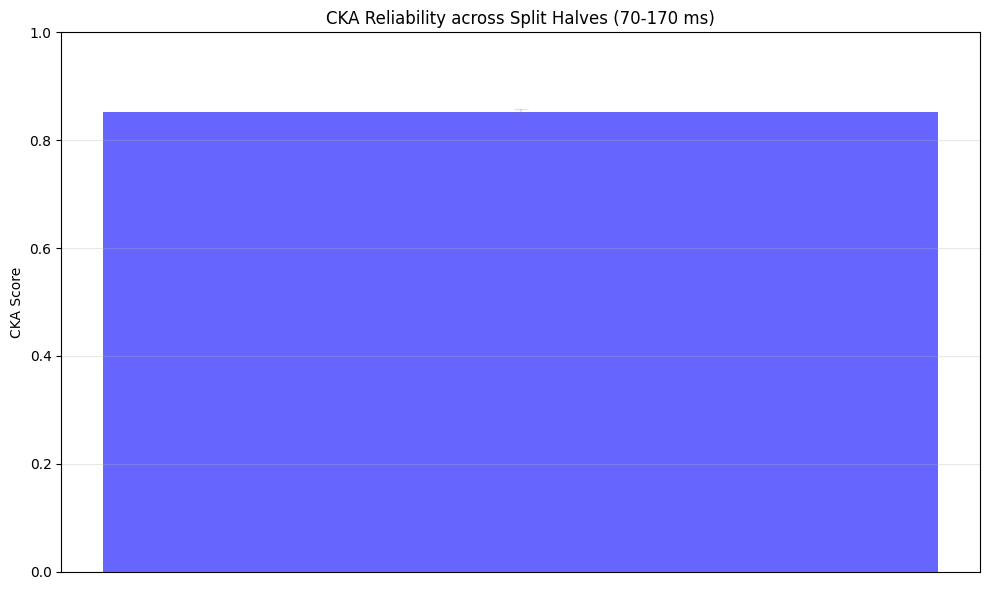

In [34]:
plt.figure(figsize=(10, 6))
plt.bar([0], [mean_rel], yerr=[std_rel], 
        error_kw=dict(ecolor='grey', alpha=0.2, capsize=5),
        width=0.5,
        color='blue',
        alpha=0.6)

plt.title('CKA Reliability across Split Halves (70-170 ms)')
plt.ylabel('CKA Score')
plt.ylim(0, 1)  # CKA values range from 0 to 1

# Remove x-axis labels since we only have one bar
plt.xticks([])

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()